In [1]:
import torch
import torchvision
import time
from torch import nn
from torch import optim
from torch.utils import data
from Validate import validate_net
from Test import test_net
from misc import print_metrics, training_curve 
from PIL import Image
import os
import re
import argparse
from collections import defaultdict
import numpy as np
import logging
import csv
from torchvision import transforms, datasets, models
import sklearn.metrics as mtc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pathlib

In [2]:
###########################
# Checking if GPU is used
###########################

use_cuda=torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()
device=torch.device("cuda:0" if use_cuda else "mps" if use_mps else "cpu")
device

device(type='cuda', index=0)

In [12]:
########################################
# Setting basic parameters for the model
########################################           
         
batch_size=8
max_epochs=30
lr=0.0001

In [4]:
# # directory of dataset
# dir_original = "./../GrapevineDS"

# # name of new dataset
# dir_processed = "./../data_processed"


In [5]:
# data_dir = pathlib.Path(dir_original)

# set_samples = ['train', 'validation', 'test']
# print("set_samples: ", set_samples, "\n")

# CLASS_NAMES = np.array([item.name for item in sorted(data_dir.glob('*'))])												
# print("class: ", CLASS_NAMES, "\n")

# N_IMAGES = np.array([len(list(data_dir.glob(item.name+'/*.jpg'))) for item in sorted(data_dir.glob('*'))])			# number of images for class
# print("number of images for class: ", N_IMAGES, "\n")

# N_samples = np.array([(int(np.around(n*60/100)), int(np.around(n*15/100)), int(np.around(n*25/100))) for n in N_IMAGES])	# number of images for set (train,validation,test)
# print("split of dataset: \n ", N_samples, "\n")


### Preprocessing Dataset

In [9]:
# #size of new images
# # size of new images
# size = 1280, 720

# try:
#     # Check if dir_processed exists and is a directory
#     if not os.path.isdir(dir_processed):
#         # If it's not a directory, create it
#         os.makedirs(dir_processed)
# except OSError as err:
#     print(err)

# # Now create subdirectories for sets and classes
# for set_tag in set_samples:
#     os.makedirs(os.path.join(dir_processed, set_tag),exist_ok=True)
#     for class_name in CLASS_NAMES:
#         os.makedirs(os.path.join(dir_processed, set_tag, class_name), exist_ok=True)

In [6]:
# # SPLIT DATASET (and resize) *************************************
# print("Split dataset.....")

# i=0
# j=0
# k=0
# for class_name in CLASS_NAMES: # "j" cambia con il tipo di pianta [0,3]

#     print("class name: ", class_name)

#     contatore_samples = 0
#     k=0

#     array = sorted(os.listdir(dir_original + '/' + class_name))
#     #random.shuffle(array)

#     for image_name in array: # "contatore" si azzera ad ogni campo 'train' 'validation' 'test'

#         print("image: ", i)
#         i=i+1
        
#         if contatore_samples==N_samples[j][k] and k+1  < len(N_samples[j]):    # "k" cambia con train, validation, e test
#             print("updating k: ", k)
#             print(len(N_samples[j]))
#             k+=1
#             contatore_samples=0


#         img=Image.open(dir_original +'/'+class_name+'/'+image_name)
#         l,_ = img.size
#         l=int(l)
        
        
#         if l==1080 or l==720:
        
#             transposed = img.transpose(Image.ROTATE_90)
#             transposed.thumbnail(size)
#             transposed.save(dir_processed+'/'+set_samples[k]+'/'+class_name+'/'+image_name)
        
#         else:
        
#             img.thumbnail(size)
#             img.save(dir_processed+'/'+set_samples[k]+'/'+class_name+'/'+image_name)

#         contatore_samples+=1

#     j+=1

In [7]:
PATH_DATASET = './../processed_RealDS'
 
train_root_dir=os.path.join(PATH_DATASET, 'train')  
val_root_dir= os.path.join(PATH_DATASET, 'validation')
test_root_dir= os.path.join(PATH_DATASET, 'test') 
model_path=r'./realDS_checkpoints_30_32_0001/'  # set path to the folder that will store model's checkpoints

n_classes=2  # number of classes used for training

global val_f1_max


try:
    if not os.path.exists(os.path.dirname(model_path)):
        os.makedirs(os.path.dirname(model_path))
except OSError as err:
    print(err)
    
print('train root', train_root_dir)

print("Directory '% s' created" % model_path)
filename='results_plasmopara'+str(max_epochs)+'_'+'b'+str(batch_size)+'_'+'lr'+str(lr)+'_'+'resnet50'   #filename used for saving epoch-wise training details and test results 

train root ./../processed_RealDS\train
Directory './realDS_checkpoints_30_32_0001/' created


In [8]:
# ####################################
# # Training
# ####################################

trans={
 # Train uses data augmentation
 'train':
 transforms.Compose([
     transforms.Resize((224, 224)),
     #transforms.RandomRotation(degrees=15),
     #transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize([0.4762, 0.3054, 0.2368], [0.3345, 0.2407, 0.2164])
]),
 # Validation does not use augmentation
 'valid':
 transforms.Compose([
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize([0.4762, 0.3054, 0.2368], [0.3345, 0.2407, 0.2164])
 ]),

 # Test does not use augmentation
 'test':
 transforms.Compose([
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize([0.4762, 0.3054, 0.2368], [0.3345, 0.2407, 0.2164])
 ]),
}

In [10]:
class train:
    def __init__(self):

#         transform=trans['valid']
        #Generators
        training_dataset= datasets.ImageFolder(train_root_dir, transform=trans['train'])
        validation_dataset= datasets.ImageFolder(val_root_dir, transform=trans['valid'])
        test_dataset= datasets.ImageFolder(test_root_dir, transform=trans['test'])
        
        self.training_generator=data.DataLoader(training_dataset,batch_size,shuffle=True) # ** unpacks a dictionary into keyword arguments
        self.validation_generator=data.DataLoader(validation_dataset,batch_size)
        self.test_generator=data.DataLoader(test_dataset,batch_size)
       
        print('Number of Training set images:{}'.format(len(training_dataset)))
        print('Number of Validation set images:{}'.format(len(validation_dataset)))
        print('Number of Test set images:{}'.format(len(test_dataset)))
        
    def train_net(self):        
                #Initialize model
        model = torchvision.models.resnet50(weights=False).to(device)   # make weights=True if you want to download pre-trained weights   # make weights=True if you want to download pre-trained weights
        
        
#         model.load_state_dict(torch.load('./densenet121.pth',map_location='cuda'))   # provide a .pth path for already downloaded weights; otherwise comment this line out
        
        
        # Option to freeze model weights
        for param in model.parameters():
            param.requires_grad = True                       # Set param.requires_grad = False if you want to train only the last updated layers and freeze all other layers
        
        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256),
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),  
                      nn.LogSoftmax(dim=1))
        
       
        model.to(device)
        optimizer=optim.Adam(model.parameters(), lr, weight_decay=1e-4)
        scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',patience=4,verbose=True)
        criterion = nn.NLLLoss()
        val_f1_max=0.0
        epochs=[]
        lossesT=[]
        lossesV=[]

        for epoch in range(max_epochs):
            print('Epoch {}/{}'.format(epoch+1,max_epochs))
            print('-'*10)
            
            since=time.time()
            train_metrics=defaultdict(float)
            total_loss=0
            running_corrects=0
            num_steps=0
            
            all_labels_d = torch.tensor([], dtype=torch.long).to(device)
            all_predictions_d = torch.tensor([], dtype=torch.long).to(device)
            all_predictions_probabilities_d = torch.tensor([], dtype=torch.float).to(device)
            
            model.train()
            
            #Training
            for image, labels in self.training_generator:
                #Transfer to GPU:
                
                image, labels = image.to(device, dtype=torch.float32), labels.to(device)
                outputs = model(image)
                predicted_probability, predicted  = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
              
                num_steps+=image.size(0)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss+=loss.item()*image.size(0)
           
                running_corrects += torch.sum(predicted == labels.data)
                all_labels_d = torch.cat((all_labels_d, labels), 0)
                all_predictions_d = torch.cat((all_predictions_d, predicted), 0)
                all_predictions_probabilities_d = torch.cat((all_predictions_probabilities_d, predicted_probability), 0)
                
                
            y_true = all_labels_d.cpu()
            y_predicted = all_predictions_d.cpu()  # to('cpu')
            valset_predicted_probabilites = all_predictions_probabilities_d.cpu()  # to('cpu')
            
            
            #############################
            # Standard metrics 
            #############################
        
            train_micro_precision=mtc.precision_score(y_true, y_predicted, average="micro")     
            train_micro_recall=mtc.recall_score(y_true, y_predicted, average="micro")
            train_micro_f1=mtc.f1_score(y_true, y_predicted, average="micro")  
        
            train_macro_precision=mtc.precision_score(y_true, y_predicted, average="macro")     
            train_macro_recall=mtc.recall_score(y_true, y_predicted, average="macro")
            train_macro_f1=mtc.f1_score(y_true, y_predicted, average="macro")  
        
            train_mcc=mtc.matthews_corrcoef(y_true, y_predicted)
             
            
            train_metrics['loss']=total_loss/num_steps
        
            train_metrics['micro_precision']=train_micro_precision
            train_metrics['micro_recall']=train_micro_recall
            train_metrics['micro_f1']=train_micro_f1
            train_metrics['macro_precision']=train_macro_precision
            train_metrics['macro_recall']=train_macro_recall
            train_metrics['macro_f1']=train_macro_f1
            train_metrics['mcc']=train_mcc
            
            print('Training...')
            print('Train_loss:{:.3f}'.format(total_loss/num_steps))
           
            
            print_metrics(train_metrics,num_steps)

            ############################
            # Validation
            ############################
            
            model.eval()
            with torch.no_grad():
                val_loss, val_metrics, val_num_steps=validate_net(model,self.validation_generator,device,criterion)
                
            scheduler.step(val_loss)
            epochs.append(epoch)
            lossesT.append(total_loss/num_steps)
            lossesV.append(val_loss)
            
            print('.'*5)
            print('Validating...')
            print('val_loss:{:.3f}'.format(val_loss))
        
            print_metrics(val_metrics,val_num_steps)


            ##################################################################
            # Writing epoch-wise training and validation results to a csv file 
            ##################################################################

            key_name=['Epoch','Train_loss','Train_micro_precision','Train_micro_recall','Train_micro_f1','Train_macro_precision','Train_macro_recall','Train_macro_f1','Train_mcc','Val_loss','Val_micro_precision','Val_micro_recall','Val_micro_f1','Val_macro_precision','Val_macro_recall','Val_macro_f1','Val_mcc']
            train_list=[]
            train_list.append(epoch)

            try:

                with open(filename+str('.csv'), 'a',newline="") as f:
                    wr = csv.writer(f,delimiter=",")
                    if epoch==0:
                        wr.writerow(key_name)

                    for k, vl in train_metrics.items():
                        train_list.append(vl)

                    train_list.append(val_loss)

                    for k, vl in val_metrics.items():
                        train_list.append(vl)
                    zip(train_list)
                    wr.writerow(train_list)


            except IOError:
                print("I/O Error")

            
            ##############################
            # Saving best model 
            ##############################
            
            if val_metrics['micro_f1']>=val_f1_max:
                print('val micro f1 increased ({:.6f}-->{:.6f}).Saving model'.format(val_f1_max,val_metrics['micro_f1']))
                
                torch.save({'epoch':epoch+1,
                            'model_state_dict':model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'scheduler': scheduler.state_dict(), 
                            'loss':val_loss},model_path+f'/C_{epoch+1}_{batch_size}.pth')
                best_model_path=model_path+f'/C_{epoch+1}_{batch_size}.pth'
               
                val_f1_max=val_metrics['micro_f1']
                

            print('-'*10)
       
        time_elapsed=time.time()-since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        
        training_curve(epochs,lossesT,lossesV)
        epochs.clear()
        lossesT.clear()
        lossesV.clear()
        

        ############################
        #         Test
        ############################
        test_list=[]
        print('Best model path:{}'.format(best_model_path))
        best_model=torchvision.models.resnet50(weights=False).to(device)
        
        n_inputs = best_model.fc.in_features
        best_model.fc = nn.Sequential(
                      nn.Linear(n_inputs, 256),
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),
                      nn.LogSoftmax(dim=1))

 
        checkpoint=torch.load(best_model_path,map_location=device)   # loading best model
        best_model.load_state_dict(checkpoint['model_state_dict'])
        best_model.to(device)
        best_model.eval()
        with torch.no_grad():
       	       test_loss, test_metrics, test_num_steps=test_net(best_model,self.test_generator,device,criterion)

        
        print_metrics(test_metrics,test_num_steps)
        test_list.append(test_loss)
     

        for k, vl in test_metrics.items():      
            test_list.append(vl)              # append metrics results in a list
  
  
  
        ##################################################################
        # Writing test results to a csv file 
        ##################################################################

        key_name=['Test_loss','Test_micro_precision','Test_micro_recall','Test_micro_f1','Test_macro_precision','Test_macro_recall','Test_macro_f1','Test_mcc']
        try:

                with open(filename+str('.csv'), 'a',newline="") as f:
                    wr = csv.writer(f,delimiter=",")
                    wr.writerow(key_name)
                    zip(test_list)
                    wr.writerow(test_list) 
                    wr.writerow("") 
        except IOError:
                print("I/O Error")  
        return val_metrics, test_metrics

INFO: Using device: cuda:0
INFO: Starting training:
             Epochs: 30
             Batch Size: 8
             Learning Rate: 0.0001
C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Number of Training set images:1600
Number of Validation set images:19
Number of Test set images:30


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/30
----------
Training...
Train_loss:0.246
loss:0.245695,micro_precision:0.900625,micro_recall:0.900625,micro_f1:0.900625,macro_precision:0.901017,macro_recall:0.900625,macro_f1:0.900601,mcc:0.801642


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....
Validating...
val_loss:0.858
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.000000-->0.894737).Saving model
----------
Epoch 2/30
----------
Training...
Train_loss:0.076
loss:0.075685,micro_precision:0.978125,micro_recall:0.978125,micro_f1:0.978125,macro_precision:0.978132,macro_recall:0.978125,macro_f1:0.978125,mcc:0.956257
.....
Validating...
val_loss:0.873
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 3/30
----------
Training...
Train_loss:0.048
loss:0.048194,micro_precision:0.988125,micro_recall:0.988125,micro_f1:0.988125,macro_precision:0.988132,macro_recall:0.988125,macro_f1:0.988125,mcc:0.976257
.....
Validating...
val_loss:0.744
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 4/30
----------
Training...
Train_loss:0.036
loss:0.035699,micro_precision:0.992500,micro_recall:0.992500,micro_f1:0.992500,macro_precision:0.992500,macro_recall:0.992500,macro_f1:0.992500,mcc:0.985000


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....
Validating...
val_loss:0.360
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model
----------
Epoch 5/30
----------
Training...
Train_loss:0.052
loss:0.052152,micro_precision:0.988750,micro_recall:0.988750,micro_f1:0.988750,macro_precision:0.988762,macro_recall:0.988750,macro_f1:0.988750,mcc:0.977512
.....
Validating...
val_loss:0.314
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 6/30
----------
Training...
Train_loss:0.029
loss:0.029468,micro_precision:0.990625,micro_recall:0.990625,micro_f1:0.990625,macro_precision:0.990626,macro_recall:0.990625,macro_f1:0.990625,mcc:0.981251
.....
Validating...
val_loss:0.864
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 7/30
----------
Training...
Train_loss:0.022
loss:0.022394,micro_precision:0.993125,micro_recall:0.993125,micro_f1:0.993125,macro_precision:0.993126,macro_recall:0.993125,macro_f1:0.993125,mcc:0.986251
.....
Validating...
val_loss:0.809
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 8/30
----------
Training...
Train_loss:0.026
loss:0.026072,micro_precision:0.993125,micro_recall:0.993125,micro_f1:0.993125,macro_precision:0.993126,macro_recall:0.993125,macro_f1:0.993125,mcc:0.986251
.....
Validating...
val_loss:0.947
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 9/30
----------
Training...
Train_loss:0.030
loss:0.030226,micro_precision:0.991250,micro_recall:0.991250,micro_f1:0.991250,macro_precision:0.991250,macro_recall:0.991250,macro_f1:0.991250,mcc:0.982500
.....
Validating...
val_loss:0.859
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 10/30
----------
Training...
Train_loss:0.032
loss:0.032125,micro_precision:0.995000,micro_recall:0.995000,micro_f1:0.995000,macro_precision:0.995012,macro_recall:0.995000,macro_f1:0.995000,mcc:0.990012
.....
Validating...
val_loss:0.594
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 11/30
----------
Training...
Train_loss:0.021
loss:0.020717,micro_precision:0.995625,micro_recall:0.995625,micro_f1:0.995625,macro_precision:0.995632,macro_recall:0.995625,macro_f1:0.995625,mcc:0.991257
.....
Validating...
val_loss:0.737
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 12/30
----------
Training...
Train_loss:0.004
loss:0.003973,micro_precision:1.000000,micro_recall:1.000000,micro_f1:1.000000,macro_precision:1.000000,macro_recall:1.000000,macro_f1:1.000000,mcc:1.000000
.....
Validating...
val_loss:0.780
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 13/30
----------
Training...
Train_loss:0.030
loss:0.030237,micro_precision:0.995625,micro_recall:0.995625,micro_f1:0.995625,macro_precision:0.995663,macro_recall:0.995625,macro_f1:0.995625,mcc:0.991288
.....
Validating...
val_loss:0.753
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 14/30
----------
Training...
Train_loss:0.017
loss:0.016745,micro_precision:0.996875,micro_recall:0.996875,micro_f1:0.996875,macro_precision:0.996876,macro_recall:0.996875,macro_f1:0.996875,mcc:0.993751
.....
Validating...
val_loss:0.731
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 15/30
----------
Training...
Train_loss:0.011
loss:0.011379,micro_precision:0.996875,micro_recall:0.996875,micro_f1:0.996875,macro_precision:0.996882,macro_recall:0.996875,macro_f1:0.996875,mcc:0.993757


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....
Validating...
val_loss:0.779
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model
----------
Epoch 16/30
----------
Training...
Train_loss:0.007
loss:0.007477,micro_precision:0.996875,micro_recall:0.996875,micro_f1:0.996875,macro_precision:0.996882,macro_recall:0.996875,macro_f1:0.996875,mcc:0.993757


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....
Validating...
val_loss:0.790
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model
----------
Epoch 17/30
----------
Training...
Train_loss:0.014
loss:0.014232,micro_precision:0.998125,micro_recall:0.998125,micro_f1:0.998125,macro_precision:0.998132,macro_recall:0.998125,macro_f1:0.998125,mcc:0.996257
.....
Validating...
val_loss:0.761
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 18/30
----------
Training...
Train_loss:0.009
loss:0.009041,micro_precision:0.998750,micro_recall:0.998750,micro_f1:0.998750,macro_precision:0.998753,macro_recall:0.998750,macro_f1:0.998750,mcc:0.997503
.....
Validating...
val_loss:0.751
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 19/30
----------
Training...
Train_loss:0.004
loss:0.003549,micro_precision:0.999375,micro_recall:0.999375,micro_f1:0.999375,macro_precision:0.999376,macro_recall:0.999375,macro_f1:0.999375,mcc:0.998751
.....
Validating...
val_loss:0.737
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 20/30
----------
Training...
Train_loss:0.006
loss:0.005787,micro_precision:0.998125,micro_recall:0.998125,micro_f1:0.998125,macro_precision:0.998126,macro_recall:0.998125,macro_f1:0.998125,mcc:0.996251


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....
Validating...
val_loss:0.761
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model
----------
Epoch 21/30
----------
Training...
Train_loss:0.018
loss:0.017726,micro_precision:0.995625,micro_recall:0.995625,micro_f1:0.995625,macro_precision:0.995644,macro_recall:0.995625,macro_f1:0.995625,mcc:0.991269


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....
Validating...
val_loss:0.824
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model
----------
Epoch 22/30
----------
Training...
Train_loss:0.009
loss:0.009198,micro_precision:0.998750,micro_recall:0.998750,micro_f1:0.998750,macro_precision:0.998753,macro_recall:0.998750,macro_f1:0.998750,mcc:0.997503
.....
Validating...
val_loss:0.834
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 23/30
----------
Training...
Train_loss:0.011
loss:0.011282,micro_precision:0.998750,micro_recall:0.998750,micro_f1:0.998750,macro_precision:0.998753,macro_recall:0.998750,macro_f1:0.998750,mcc:0.997503
.....
Validating...
val_loss:0.781
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 24/30
----------
Training...
Train_loss:0.010
loss:0.009896,micro_precision:0.998125,micro_recall:0.998125,micro_f1:0.998125,macro_precision:0.998132,macro_recall:0.998125,macro_f1:0.998125,mcc:0.996257


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....
Validating...
val_loss:0.777
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model
----------
Epoch 25/30
----------
Training...
Train_loss:0.003
loss:0.003032,micro_precision:1.000000,micro_recall:1.000000,micro_f1:1.000000,macro_precision:1.000000,macro_recall:1.000000,macro_f1:1.000000,mcc:1.000000
.....
Validating...
val_loss:0.827
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 26/30
----------
Training...
Train_loss:0.011
loss:0.010709,micro_precision:0.998125,micro_recall:0.998125,micro_f1:0.998125,macro_precision:0.998126,macro_recall:0.998125,macro_f1:0.998125,mcc:0.996251


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....
Validating...
val_loss:0.840
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model
----------
Epoch 27/30
----------
Training...
Train_loss:0.015
loss:0.014570,micro_precision:0.995625,micro_recall:0.995625,micro_f1:0.995625,macro_precision:0.995663,macro_recall:0.995625,macro_f1:0.995625,mcc:0.991288


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


.....
Validating...
val_loss:0.783
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model
----------
Epoch 28/30
----------
Training...
Train_loss:0.011
loss:0.011355,micro_precision:0.996875,micro_recall:0.996875,micro_f1:0.996875,macro_precision:0.996882,macro_recall:0.996875,macro_f1:0.996875,mcc:0.993757
.....
Validating...
val_loss:0.815
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 29/30
----------
Training...
Train_loss:0.003
loss:0.002869,micro_precision:1.000000,micro_recall:1.000000,micro_f1:1.000000,macro_precision:1.000000,macro_recall:1.000000,macro_f1:1.000000,mcc:1.000000
.....
Validating...
val_loss:0.793
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
Epoch 30/30
----------
Training...
Train_loss:0.010
loss:0.010268,micro_precision:0.998750,micro_recall:0.998750,micro_f1:0.998750,macro_precision:0.998753,macro_recall:0.998750,macro_f1:0.998750,mcc:0.997503
.....
Validating...
val_loss:0.821
micro_precision:0.894737,micro_recall:0.894737,micro_f1:0.894737,macro_precision:0.447368,macro_recall:0.500000,macro_f1:0.472222,mcc:0.000000
val micro f1 increased (0.894737-->0.894737).Saving model


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------
0m 16s
Best model path:./realDS_checkpoints_30_32_0001//C_30_8.pth


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this

Accuracy of the network on the 30 test images: 93.333336 %
[[28  0]
 [ 2  0]]
taking class names to plot CM
Generating confution matrix
Confusion matrix, without normalization
[[28  0]
 [ 2  0]]
Finished confusion matrix drawing...
              precision    recall  f1-score   support

     Disease       0.93      1.00      0.97        28
     Healthy       0.00      0.00      0.00         2

    accuracy                           0.93        30
   macro avg       0.47      0.50      0.48        30
weighted avg       0.87      0.93      0.90        30

micro_precision:0.933333,micro_recall:0.933333,micro_f1:0.933333,macro_precision:0.466667,macro_recall:0.500000,macro_f1:0.482759,mcc:0.000000


C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User1\anaconda3\envs\GrapevineDS\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(defaultdict(float,
             {'micro_precision': 0.8947368421052632,
              'micro_recall': 0.8947368421052632,
              'micro_f1': 0.8947368421052632,
              'macro_precision': 0.4473684210526316,
              'macro_recall': 0.5,
              'macro_f1': 0.4722222222222222,
              'mcc': 0.0}),
 defaultdict(float,
             {'micro_precision': 0.9333333333333333,
              'micro_recall': 0.9333333333333333,
              'micro_f1': 0.9333333333333333,
              'macro_precision': 0.4666666666666667,
              'macro_recall': 0.5,
              'macro_f1': 0.4827586206896552,
              'mcc': 0.0}))

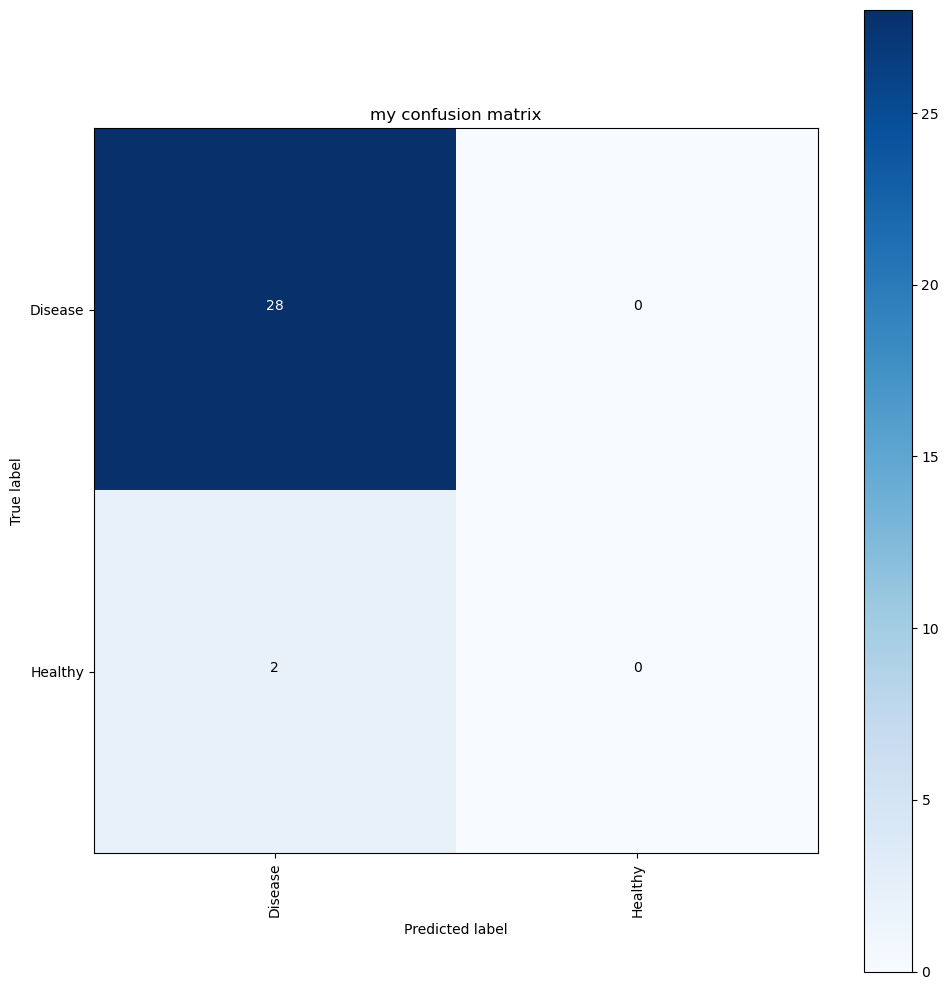

In [13]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logging.info(f'Using device: {device}')
logging.info(f'''Starting training:
             Epochs: {max_epochs}
             Batch Size: {batch_size}
             Learning Rate: {lr}''')
t=train()
t.train_net()